---  
title: "Timely and effective care"  
subtitle: "An analysis of the public dataset from CMS"  
date: last-modified  
date-format: full  
author:  
  - name:  
      given: Pranav Kumar  
      family: Mishra  
    affiliations:  
      - ref: rushsurg  
      - ref: rushortho  
    corresponding: true  
    url: https://drpranavmishra.com  
    email: pranav_k_mishra@rush.edu  
    orcid: 0000-0001-5219-6269  
    role: "Post Doctoral Research Fellow"  
format:  
  html:  
    code-fold: true  

  pdf:
    documentclass: scrartcl
    toc: true
    code-fold: true
    papersize: letter
    toc-depth: 2
    margin-left: 30mm
    margin-right: 30mm
    highlight-style: github
    colorlinks: true
    default-image-extension: png 
execute:   
  enabled: false  
  echo: false  
  output: asis #true  
---

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import requests
from io import StringIO
import json
import sys
import os
import glob
import socket
import pyreadstat


import itertools
import datalad.api as dl

# Plotting
from matplotlib import pyplot as plt
from matplotlib.ticker import (
    MultipleLocator,
    FormatStrFormatter,
    AutoMinorLocator,
    MaxNLocator,
)
from matplotlib import ticker
from matplotlib import image as image
from matplotlib import cbook as cbook
from matplotlib.colors import ListedColormap
from matplotlib.image import imread
from matplotlib.dates import DateFormatter
from matplotlib import rc, rcParams
import cycler

import matplotlib.pyplot as plt
from PIL import Image as ImagePIL
from IPython.display import display
from skimage.transform import resize
from io import BytesIO

from tabulate import tabulate
import json

# Date and time formatting
import datetime as date

# For grabbing URLs
import urllib
import math
import re
import csv

# Map
from geopy.geocoders import Nominatim
import folium

# Display
from IPython.display import display, Markdown, Latex


In [2]:
# General
verbosity = True
repository_root = "/home/pranav/work/pranavmishra90/courses/by-mishra/research-data-management"

In [3]:
# Get the computer name and the repository root

# Get the name of the computer, then save it to an environment variable
os.environ['computer_name']= socket.gethostname()

if len(os.environ['computer_name']) == 12:
    if os.path.exists('/home/coder/work'):
        
        is_docker = 'True'
        os.environ['is_docker']=is_docker
        os.chdir('/home/coder/work')
        os.environ['repo_root']=os.getcwd()
        print('This is a docker environment')

    
   
elif os.path.exists(repository_root) == True:
    is_docker = 'False'
    os.environ['is_docker'] = is_docker
    os.environ['repo_root'] = repository_root

else:
    is_docker = 'False'
    os.environ['is_docker'] = is_docker
    print(f"Error finding the repository root for computer {os.environ['computer_name']}")


print(f"The computer\'s name is {os.environ['computer_name']}")
os.chdir(os.environ['repo_root'])
print(f"The current directory has been set to {os.getcwd()}")

The computer's name is pminformatics.rush.edu

The current directory has been set to /home/pranav/work/pranavmishra90/courses/by-mishra/research-data-management

In [4]:
# Library of functions
#!/usr/bin/env python
#

#
# Created by:
#
# Pranav Kumar Mishra, MD
# Post-Doctoral Research Fellow
# Departments of Surgery and Orthopedic Surgery
# Rush University Medical Center
#
# Email: pranav_k_mishra@rush.edu
# Phone: 312-942-3146
#
# ### License: **MIT License**
#
# Copyright (c) 2023-2024 Pranav Kumar Mishra (Rush University, Chicago, IL)
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# ## Import libraries

# General
import os
import socket
from IPython.display import display
import datetime as date
from copy import deepcopy
import warnings
import shutil
from configparser import ConfigParser

# Searching
import json

# Graphing
import seaborn as sns
from matplotlib.dates import DateFormatter
from matplotlib.image import imread
from matplotlib.colors import ListedColormap
from matplotlib import cbook as cbook
from matplotlib import image as image
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams

# Data files
import datalad.api as dl

# Web
import urllib
import requests


# Images
from skimage.transform import resize
from PIL import Image as ImagePIL

# Statistics
from scipy.stats import gmean, mannwhitneyu, normaltest
import numpy as np
import pandas as pd
import math

import csv
import re
import six

# Progress bars
stdout_fig_gen = False
if stdout_fig_gen == False:
    # Inline progress
    from tqdm.auto import tqdm
else:
    # Popup progress
    from tkinter import Tk
    from tqdm.tk import tqdm

# Date formatting
execute_start_time = date.datetime.now()
date_readable_format = "%A, %b %d, %Y at %I:%M:%S %p"
date_machine_format = "%Y-%m-%d_%H%M%S"
file_date = f"{date.datetime.now().strftime('%Y-%m-%d')}"


# In[ ]: Create a python dictionary from a CSV file
# -----------------------------------------------------------------------
def csv_to_dict(csvfilepath):
    # Open the CSV file and read its contents
    with open(csvfilepath, "r") as file:
        reader = csv.reader(file)

        # Create a dictionary to hold the data
        my_dict = {}

        # Loop through each row of the CSV and add its data to the dictionary
        for row in reader:
            # print(row) #Uncomment this row for debugging
            key = row[0]
            value = row[1]
            my_dict[key] = value

        return my_dict


# In[ ]: Fix nan inside of a dataframe
# -----------------------------------------------------------------------
def fix_nan(dataframe):
    dataframe = dataframe.replace(r"-99", "", regex=True)
    dataframe = dataframe.replace(-99, np.nan, regex=False)

    return dataframe


# In[ ]: Within a dataframe's column, perform a find and replace
# -----------------------------------------------------------------------
def find_and_replace_df(input_df, column_name, input_sample, replace_sample):
    df = deepcopy(input_df.loc[input_df[column_name] == input_sample])
    df[column_name] = replace_sample

    output_limited2 = input_df

    output_limited2.loc[df.index] = np.nan

    output_limited2 = output_limited2.combine_first(df)

    return output_limited2


# In[ ]: Change dataframe column dtypes according to a python dictionary
# -----------------------------------------------------------------------
def fix_column_dtype(dataframe, dtype_dict):
    # List all of the columns in the dataframe
    columns = dataframe.columns.tolist()

    # Converting NaN values to -99
    for col in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            # Fill NaN values with -99 for numeric columns
            dataframe[col] = dataframe[col].fillna(-99)
        elif dataframe[col].dtype == "object":
            # Fill NaN values with '-99' for string columns
            dataframe[col] = dataframe[col].fillna("-99")

    dataframe = dataframe.convert_dtypes(convert_floating=True)

    for col in columns:
        # Debugging -------
        # If you are getting an error loading the dictionary file, uncommon the following print line. The last printed item is the problemmatic one in your dictionary of dtypes
        # print(f"Converting {col} to {dtype_dict[col]}")
        # -----------------
        dataframe = dataframe
        try:
            dataframe[col] = dataframe[col].astype(dtype_dict[col])
        except:
            print(f"Error changing dtype: {col} to {dtype_dict[col]}")

    nan_replaced = fix_nan(dataframe)

    return nan_replaced  # Export the dataframe


# In[ ]: Generate a matplotlib table 'figure' from a pandas dataframe
# -----------------------------------------------------------------------
def render_mpl_table(
    data,
    col_width=3.0,
    row_height=0.625,
    font_size=14,
    header_color="#40466e",
    row_colors=["#f1f1f2", "w"],
    edge_color="w",
    bbox=[0, 0, 1, 1],
    header_columns=0,
    ax=None,
    **kwargs,
):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array(
            [col_width, row_height]
        )
        fig, ax = plt.subplots(figsize=size)
        ax.axis("off")

    mpl_table = ax.table(
        cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs
    )

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight="bold", color="w")
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    return ax


# In[ ]: Label bars with values
# -----------------------------------------------------------------------
def add_value_labels(ax1, label_size, spacing=5):
    # """Add labels to the end of each bar in a bar chart.

    # Arguments:
    #     ax (matplotlib.axes.Axes): The matplotlib object containing the axes
    #         of the plot to annotate.
    #     spacing (int): The distance between the labels and the bars.
    # """

    # For each bar: Place a label
    for rect in ax1.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = "bottom"

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = "top"

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax1.annotate(
            label,  # Use `label` as label
            (x_value, y_value),  # Place label at end of the bar
            xytext=(0, space),  # Vertically shift label by `space`
            textcoords="offset points",  # Interpret `xytext` as offset in points
            ha="center",  # Horizontally center label
            va=va,
            fontsize=label_size * 0.8,
        )  # Vertically align label differently for
        # positive and negative values.


# In[ ]: Move files recursively
# -----------------------------------------------------------------------
def move_files_recursively(source, destination):
    if not os.path.exists(destination):
        os.makedirs(destination)

    for item in os.listdir(source):
        item_path = os.path.join(source, item)
        destination_path = os.path.join(destination, item)

        if os.path.isfile(item_path):
            shutil.move(item_path, destination_path)
        elif os.path.isdir(item_path):
            shutil.move(item_path, destination_path)
            move_files_recursively(destination_path, destination)


def sort_json_dictionary(json_data):
    data = json.loads(json_data)
    sorted_data = {}
    sorted_data = dict(sorted(data.items()))

    for key, values in data.items():
        sorted_data[key] = sorted(values)

    sorted_json_data = json.dumps(sorted_data, indent=4)

    return sorted_json_data


def load_json_to_dict(file_path):
    with open(file_path, "r") as file:
        json_data = json.load(file)

    sorted_data = {}
    sorted_data = dict(sorted(json_data.items()))

    for key, values in json_data.items():
        sorted_data[key] = sorted(values)

    sorted_json_data = json.dumps(sorted_data, indent=4)

    return sorted_json_data


# In[ ]: ######## Figure definitions and functions ##################
# Formatting the following figures----------------------------------------

title_fontsize = 20
title_pad = 20

axes_fontsize = 16
axes_label_pad = 15
label_size = 12
xticks_size = 10

fig_dpi = 75
fig_display_dpi = 300
fig_save_dpi = 300
fig_save_dpi_scalar = 0.6
fig_width = 10
fig_height = 5
data_source_alpha = 0.9

image_filetype = "png"

# Legend
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Watermarks
project_name = "Research Data Management"
created_by = "Pranav Kumar Mishra"
subtitle_line1 = "Post Doctoral Research Fellow"
subtitle_line2 = ""
subtitle_line3 = "Updated: " + date.datetime.today().strftime("%Y-%m-%d")

data_source = (
    project_name
    + "\n"
    + created_by
    + "\n"
    + subtitle_line1
    + "\n"
    + subtitle_line2
    + "\n"
    + subtitle_line3
)
# data_source = ""

# watermark_text = 'DRAFT'
watermark_text = ""
watermark_text_alpha = 0.2  # 0.2
watermark_font_size = 100

image_path = "code/jupyter/rush-university-logo.png"

# Get the dimensions x, y of the image logo watermark
pil_im = ImagePIL.open(image_path)
pil_im = [int(i) for i in pil_im.size]

dimensions = list(reversed(pil_im))
dimensions = [int(dim) for dim in dimensions]
image_size_scalar = (fig_save_dpi * fig_width / 5) / dimensions[1]
dimensions_new = [int(dim * image_size_scalar) for dim in dimensions]

# Load the image
image_watermark = np.array(ImagePIL.open(image_path))

image_watermark_alpha = 0.9  # 0.9

# Resize the image
image_watermark = resize(image_watermark, dimensions_new)
# display(image_watermark.shape)

rush_colors_hex = [
    "#00B480",
    "#006332",
    "#4EC5D8",
    "#EA6852",
    "#F2CD00",
    "#006E96",
    "#B12028",
    "#F5A700",
]
rush_cmap = ListedColormap(rush_colors_hex)

file_date = f"{date.datetime.now().strftime('%Y-%m-%d')}"

# Seaborn styling
custom_params = {
    "axes.spines.right": True,
    "axes.spines.top": True,
}
sns.set_theme(style="white", palette="muted", rc=custom_params)

file_date = f"{date.datetime.now().strftime('%Y-%m-%d')}"



plt.close()

# Legend
legend_title_fontsize = 12


# In [ ]: Label bars with values
# ------------------------------------------------------------------------


def add_value_labels(ax1, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax1.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = "bottom"

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = "top"

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax1.annotate(
            label,  # Use `label` as label
            (x_value, y_value),  # Place label at end of the bar
            xytext=(0, space),  # Vertically shift label by `space`
            textcoords="offset points",  # Interpret `xytext` as offset in points
            ha="center",  # Horizontally center label
            va=va,
            fontsize=label_size * 0.8,
        )  # Vertically align label differently for
        # positive and negative values.


# In [ ]: Find a subdirectory given a pattern, using regex
# ------------------------------------------------------------------------
def find_subdirectory_with_pattern(input_path, pattern):
    print(f"Looking in directory: {input_path}\nWith the pattern: {pattern}\n")
    subdirectories = next(os.walk(input_path))[1]
    regex_pattern = re.compile(pattern)

    for subdirectory in subdirectories:
        if regex_pattern.match(subdirectory):
            # If the pattern matches, return out of the function
            found_subdirectory = os.path.join(input_path, subdirectory)
            print(f"Found: {found_subdirectory}")

            return found_subdirectory

    # Return nothing from the function outside of the 'for' loop
    return None


# In[ ]: Save a dataframe to the hard drive (CSV, parquet, etc.)
# --------------------------------------------------------------
def save_dataframe_table(df, table_filetypes_output):
    for table_filetype in table_filetypes_output:
        table_path = (
            tables_base_path
            + "/"
            + output_directory_major
            + output_filename_prefix
            + output_filename_main
            + output_filename_suffix
            + f".{table_filetype}"
        )

        if table_filetype == "csv":
            df.to_csv(table_path)

        if table_filetype == "parquet":
            df.to_parquet(table_path)
    
        if table_filetype == "sav":
            pyreadstat.write_sav(df, table_path)


# In[ ]: Calculate Mann-Whitney U Tests for all x-axis categories
# ----------------------------------------------------------------
def calc_stats_mwu(dataset, x_variable, y_variable):
    visit_pairing = itertools.combinations(study_period_list, 2)

    print("Mann-Whitney U Test")
    print("-------------------------------------------------------------------")

    print(f"Testing significance between the variables:")
    print(f" - `{x_variable}`")
    print(f" - `{y_variable}`")
    print(" ")
    print(f"selected_variable = `{selected_variable}`")

    print(" ")
    print(" ")
    print(" ")

    ## First print the statistically significant pairings
    print("-------------------------------------------------------------------")
    print(f"Statistically significant changes in {selected_variable} between:")
    print("-------------------------------------------------------------------")

    for combination in visit_pairing:
        data1 = dataset[dataset[x_variable] == combination[0]][selected_variable]
        data2 = dataset[dataset[x_variable] == combination[1]][selected_variable]

        stat, p = stats.mannwhitneyu(data1, data2)

        # interpret

        if 0.01 <= p <= 0.05:
            print(
                f"[*] Statistically SIGNIFICANT change in {selected_variable} between {combination[0]} and {combination[1]}. p = {round(p, 4)}"
            )
            print(" ")

        elif 0.001 <= p < 0.01:
            print(
                f"[**] Statistically SIGNIFICANT change in {selected_variable} between {combination[0]} and {combination[1]}. p = {round(p, 4)}"
            )
            print(" ")

        elif p < 0.001:
            print(
                f"[***] Statistically SIGNIFICANT change in {selected_variable} between {combination[0]} and {combination[1]}. p = {round(p, 4)}"
            )
            print(" ")

    ## Then print the non-statistically significant pairings
    print("-----------------------------------------------------------------------")
    print(f"No statistically significant changes in {selected_variable} between:")
    print("-----------------------------------------------------------------------")
    visit_pairing = itertools.combinations(study_period_list, 2)
    for combination in visit_pairing:
        data1 = dataset[dataset[x_variable] == combination[0]][selected_variable]
        data2 = dataset[dataset[x_variable] == combination[1]][selected_variable]

        stat, p = stats.mannwhitneyu(data1, data2)
        # interpret
        if p > 0.05:
            print(f"{combination[0]} and {combination[1]} (p = {round(p, 4)})")

            print(" ")


# In[ ]: Drop columns by a regex name search
# ----------------------------------------------------------------
def drop_columns_regex (dataframe, regex):
    
    #List all of the columns in the dataframe
    columns = dataframe.columns.tolist()

    # display(regex)

    deleted_columns = []

    for col in columns:
        if re.match(regex,col): #regex
            deleted_columns.append([col])
            dataframe = dataframe.drop([col], axis=1, inplace=False) # If regex matches, then remove the column

    if verbosity == True:
        display(f'The following columns have been deleted: {deleted_columns}')

    return dataframe #Export the dataframe



# In[ ]: Comma formatted number in a string
# ----------------------------------------------------------------

def comma_formatted_num(number):
	formatted = ('{:,}'.format((number)))

	return formatted

def mddisplay(string):
	display(Markdown(string))

# In[ ]:  Function to calculate missing values by column
# ----------------------------------------------------------------
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
######################################################################################

## Import Data

In [5]:
dl.get("data/raw/cms/")
care_raw_df = pd.read_csv("data/raw/cms/Healthcare_Associated_Infections-Hospital.csv")

In [6]:
il_zip_df = pd.read_csv("code/library/zip-codes.csv")
il_zip_codes = il_zip_df['il_zip_codes'].to_list()

## Parameters

In [7]:
# Run Parameters
run_num = '001'

zipcode_filter = il_zip_codes

input_start_date = "2022-07-01"
input_end_date = "2024-12-01"

zip_start = 0
zip_end = 99999


# Figures
image_filetypes_output = ["jpg"]
data_source_alpha = 0
watermark_text_alpha = 0
watermarks = True
errorbartype = ("ci", 95) 

save_figures = True

# Tables
table_filetypes_output = ['parquet', 'csv']
save_tables = True

In [8]:
# Parameters
run_num = 1
zip_start = 60002
zip_end = 62999
save_figures = True
save_tables = True


In [9]:
run_num = str(run_num).zfill(3)

In [10]:
filter_start_date = pd.to_datetime(input_start_date)
filter_end_date = pd.to_datetime(input_end_date)

In [11]:
# Create directories
run_base_directory = "data/analysis/timely_effective/runs"

this_run_directory = os.path.join(run_base_directory, "run_" + run_num)

if not os.path.exists(this_run_directory):
    print(f"Creating a new directory at: {this_run_directory}")
    os.makedirs(this_run_directory)

else:
    # raise SystemExit(f"Caution: The run directory already exists for Run # {run_num}")

    print(f"Caution: The run directory already exists for Run # {run_num}")

# Figures directory
figure_base_path = os.path.join(os.environ["repo_root"], this_run_directory, "figures/")
if not os.path.exists(figure_base_path):
    os.makedirs(figure_base_path)
else:
    print(f"A figures directory is already present: {figure_base_path}")


# Tables directory
tables_base_path = os.path.join(os.environ["repo_root"], this_run_directory, "tables/")
if not os.path.exists(tables_base_path):
    os.makedirs(tables_base_path)
else:
    print(f"A tables directory is already present: {tables_base_path}")

# Notebook directory
notebook_base_path = os.path.join(
    os.environ["repo_root"], this_run_directory, "notebooks/"
)
if not os.path.exists(notebook_base_path):
    os.makedirs(notebook_base_path)
else:
    print(f"A notebook directory is already present: {notebook_base_path}")


Caution: The run directory already exists for Run # 001

A notebook directory is already present: /home/pranav/work/pranavmishra90/courses/by-mishra/research-data-management/data/analysis/timely_effective/runs/run_001/notebooks/

## Data Processing

### Data Sanitization

In [12]:
care_df_tmp = care_raw_df.copy()

# Remove missing data
care_df_tmp.loc[:, 'Score'] = care_df_tmp['Score'].replace("Not Available", np.nan)
care_df_tmp.loc[:, 'Score'] = care_df_tmp['Score'].replace("--", np.nan)
care_df_tmp['Score'] = pd.to_numeric(care_df_tmp['Score'], errors='coerce')

# Set date formats to datetime
care_df_tmp.loc[:, 'Start Date'] = pd.to_datetime(care_df_tmp['Start Date'], format='%m/%d/%Y')
invalid_dates = care_df_tmp['Start Date'].isna()
care_df_tmp = care_df_tmp[~invalid_dates]
care_df_tmp.loc[:, 'End Date'] = pd.to_datetime(care_df_tmp['End Date'], format='%m/%d/%Y')
invalid_dates = care_df_tmp['End Date'].isna()
care_df_tmp = care_df_tmp[~invalid_dates]

care_df_tmp[['Start Date', 'End Date']] = care_df_tmp[['Start Date', 'End Date']].astype('datetime64[ns]')

# Drop extraneous columns
care_df_tmp = care_df_tmp.drop(columns=['Address', 'Telephone Number'])

care_df_tmp.dtypes

Facility ID                     object
Facility Name                   object
City/Town                       object
State                           object
ZIP Code                         int64
County/Parish                   object
Measure ID                      object
Measure Name                    object
Compared to National            object
Score                          float64
Footnote                        object
Start Date              datetime64[ns]
End Date                datetime64[ns]
dtype: object

### Subset the data

In [13]:
care_df = care_df_tmp[(care_df_tmp["ZIP Code"].isin(zipcode_filter)) & (care_df_tmp["Start Date"] >= filter_start_date) & (care_df_tmp["End Date"] <= filter_end_date)]

In [14]:
display(Markdown(f"""# Filtering for Zipcode:

The raw dataset `care_raw_df` has `{comma_formatted_num(care_raw_df['ZIP Code'].nunique())}` zip codes with `{comma_formatted_num(care_raw_df.shape[0])}` facilities.

After filtering, `{comma_formatted_num(care_df['ZIP Code'].nunique())}` zip codes with `{comma_formatted_num(care_df.shape[0])}` facilities remain in the dataset `care_df`
"""))


# Filtering for Zipcode:

The raw dataset `care_raw_df` has `4,405` zip codes with `173,304` facilities.

After filtering, `158` zip codes with `6,264` facilities remain in the dataset `care_df`


### Outlier Analysis

In [15]:
def var_exploration_continuous(df, exploration_variable_array):

	for exploration_var in exploration_variable_array:

		mddisplay(f"## Variable exploration: `{exploration_var}`")

		# Descriptive statistics
		display(pd.DataFrame(df[exploration_var].describe()))

		mdstring = f"""
### Extremes of data

Lowest Values:

`{df[exploration_var].dropna().sort_values().head(10).to_list()}`

Highest Values:

`{df[exploration_var].dropna().sort_values().tail(10).to_list()}`
"""

		display(Markdown(mdstring))

		sns.displot(df, x=exploration_var, bins=20)

## Variable exploration: `Score`

,Score
count,3877.000000
mean,3385.893854
std,17857.281487
min,0.000000
25%,0.269000
50%,1.346000
75%,11.840000
max,329722.000000



### Extremes of data

Lowest Values:

`[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]`

Highest Values:

`[181596.0, 194569.0, 201314.0, 203229.0, 215520.0, 226034.0, 229620.0, 249798.0, 294771.0, 329722.0]`


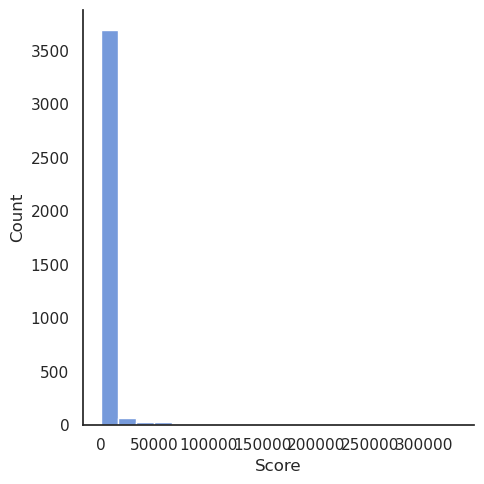

In [16]:
# Select a variable to examine
exploration_variables=['Score']

var_exploration_continuous(care_df, exploration_variables)

In [17]:
# Function: IQR based outlier analysis
def iqr_outlier_analysis(df, exploration_variables, display_outliers=True, apply_filter=False):

    # Calculate first and third quartile
    first_quartile = df[exploration_variables].quantile(0.25)
    third_quartile = df[exploration_variables].quantile(0.75)

    # Interquartile range
    iqr = third_quartile - first_quartile


    # Filter the data for outliers
    df_outliers = df[
        (df[exploration_variables] < (first_quartile - 3 * iqr))
        | (df[exploration_variables] > (third_quartile + 3 * iqr))
    ]

    cases_before = df.shape[0]
    cases_after = cases_before - df_outliers.shape[0]
    cases_removed = cases_before - cases_after

    # Print results
    display(Markdown(f"""
#### $3 \\times IQR$ Extremes for `{exploration_variables}`

- Num cases before outlier filter: `{comma_formatted_num(cases_before)}`
- IQR: `{round(iqr, 2)}` ({round(third_quartile, 2)} - {round(first_quartile, 2)})
- Outliers: `{exploration_variables} < {round((first_quartile - (3 * iqr)), 2)}` OR `{exploration_variables} > {round((third_quartile + (3 * iqr)), 2)}`
"""))
    if display_outliers == True:
        display(Markdown("**Outliers:**"))
        display(df_outliers)


    if apply_filter == True:
        # Apply filter
        df = df[~df.index.isin(df_outliers.index)]
        display(Markdown(f"Cases after the outlier filter: {comma_formatted_num(cases_after)} (Removed {cases_removed})"))
    elif apply_filter==False:
        display(Markdown(f"Outlier filter not applied. We want to study the effects of `{exploration_variables}` on the model."))

    # del data_outliers, cases_before, cases_after, cases_removed

    return df

In [18]:
care_df = iqr_outlier_analysis(care_df, "Score", display_outliers=False, apply_filter=True)


#### $3 \times IQR$ Extremes for `Score`

- Num cases before outlier filter: `6,264`
- IQR: `11.57` (11.84 - 0.27)
- Outliers: `Score < -34.44` OR `Score > 46.55`


Cases after the outlier filter: 5,496 (Removed 768)

## Generate Figures and Tables

In [19]:
earliest_date = care_df['Start Date'].min().strftime('%Y-%m-%d')
latest_date = care_df['End Date'].max().strftime('%Y-%m-%d')


run_details = f"Run {run_num} Details:\nDates: {earliest_date} - {latest_date}\nNo. Zip Codes: {care_df['ZIP Code'].nunique()}"

print(run_details)

Run 001 Details:
Dates: 2022-07-01 - 2023-06-30
No. Zip Codes: 158

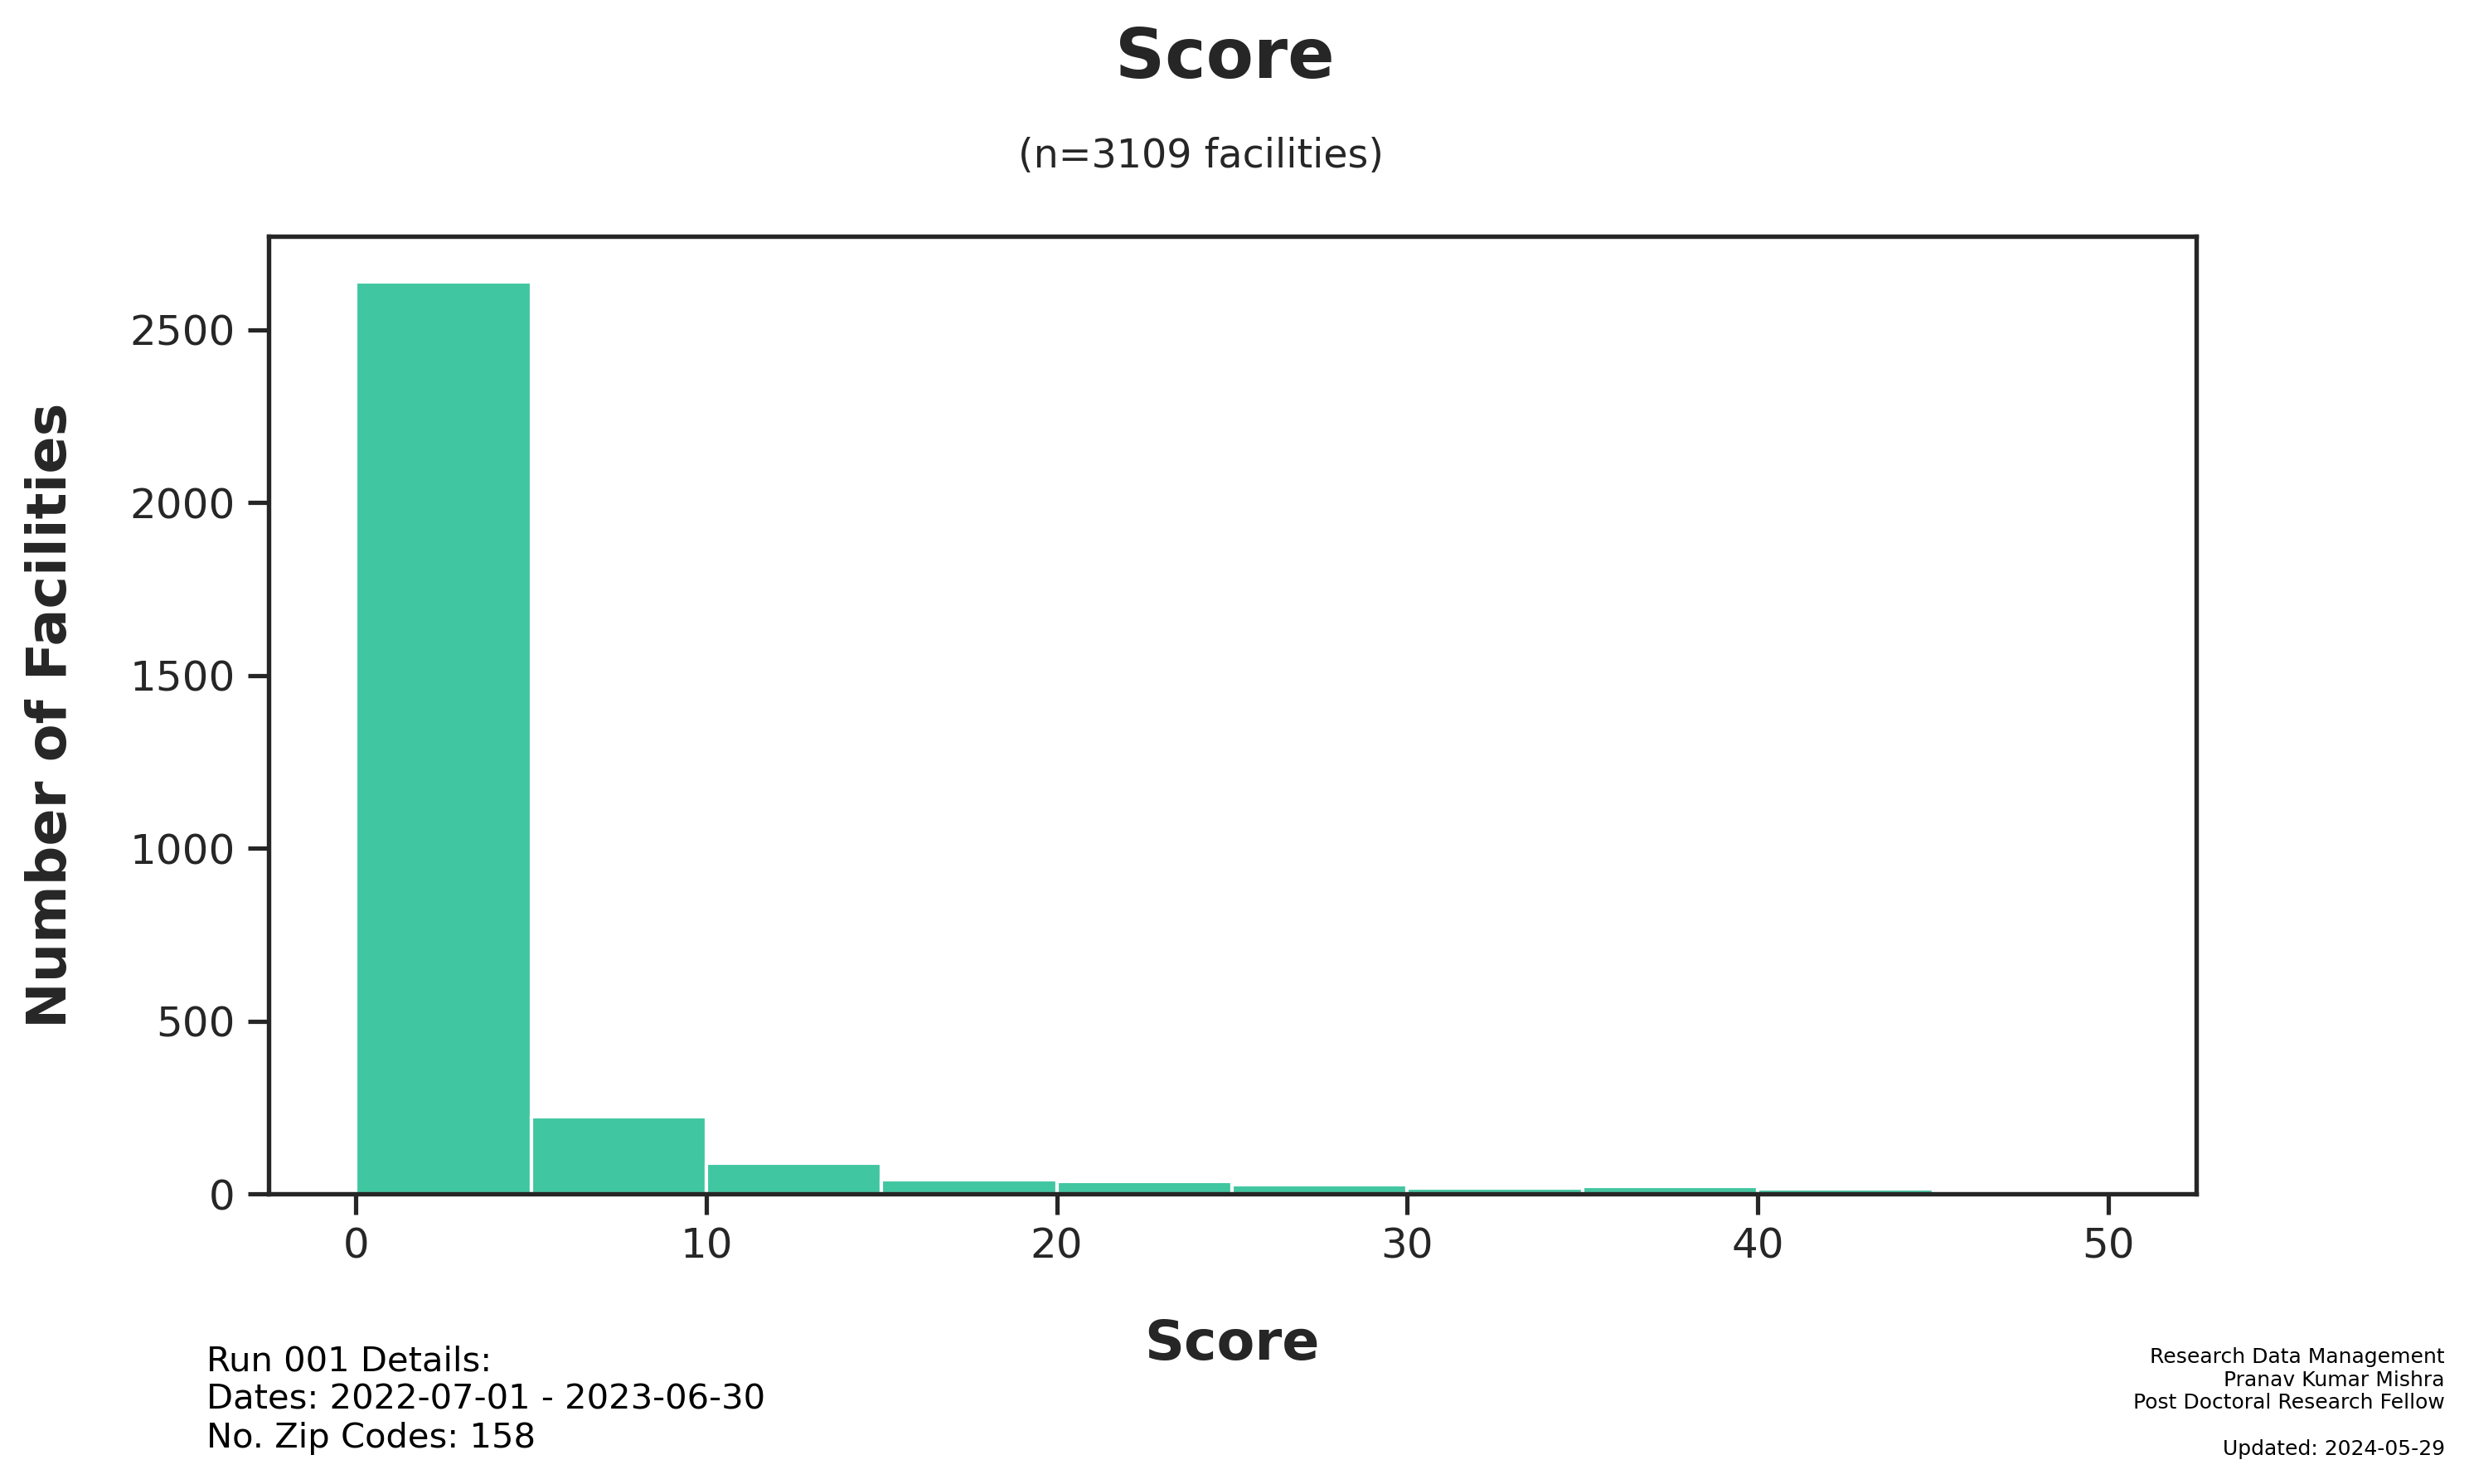

In [20]:
# Distribution of Score

# Define what will be plotted as the "dataset"
# -------------------------------------------------
selected_variable = "Score"
title_prefix = r"Distribution of "

selected_variable_title = "  Score"


x_axis_title = r"Score"
y_axis_title = r"Number of Facilities"


output_directory_major = ""
output_filename_prefix = f"Run{run_num}_TE_"
output_filename_main = f"Score_Dist"

output_filename_suffix = ""


dataset = care_df.copy().dropna(subset=[selected_variable])[selected_variable].to_frame(selected_variable)


# # --------------------------------------------------------------------------------------------

fig1, _ = plt.subplots(figsize=(fig_width, fig_height), dpi=fig_display_dpi)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=None
)

# Histogram features
# --------------------
min_x_val = round(dataset.min().iloc[0], -1)
max_x_val = round(dataset.max().iloc[0], -1)
val_width = max_x_val - min_x_val
bin_width = 5 # bin_width = val_width/n_bins
n_bins = val_width / bin_width
bin_range = (min_x_val, max_x_val)


# Seaborn Histogram
# --------------------
ax1 = sns.histplot(
    x=selected_variable,
    data=dataset,
    binwidth=bin_width,
    binrange=bin_range,
    color=rush_colors_hex[0],
)


# Plot traits
# ------------------

# Sample Size
n_samples = str(dataset.shape[0])

# Title
fig1.suptitle(
    selected_variable_title,
    fontsize=title_fontsize,
    fontweight="bold",
    y=1.05,
)
ax1.set_title(
    "(n=" + str(n_samples) + " facilities)     ",
    size=title_fontsize / 1.75,
    #   fontweight='bold',
    pad=title_pad,
)

ax1.set_xlabel(x_axis_title, fontweight="bold", size=axes_fontsize)
ax1.set_ylabel(y_axis_title, fontweight="bold", size=axes_fontsize)


ax1.tick_params(labelsize=label_size)
ax1.get_xaxis().tick_bottom()

ax1.tick_params(which="minor", length=0)
ax1.yaxis.set_ticks_position("left")
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))


ax1.xaxis.labelpad = axes_label_pad
ax1.yaxis.labelpad = axes_label_pad

ax2 = ax1.twinx()
ax2.tick_params(which="major", length=0)
ax2.set_yticks([])
ax2.set_ylabel(" ", fontweight="bold", size=axes_fontsize)
ax2.yaxis.labelpad = axes_label_pad * 2

# Watermarks
if watermarks == True:
    # Author
    fig1.text(1,-0.1, data_source, color="black", ha="right", fontsize=6)
    # Run Details
    fig1.text(0.1, -0.1, run_details, color="black", ha='left', va='bottom', fontsize=10, alpha=1)



# Save the figure
# ------------------
if not os.path.exists(os.path.join(figure_base_path, output_directory_major)):
    os.makedirs(os.path.join(figure_base_path, output_directory_major))


for image_filetype in image_filetypes_output:
    image_path = (
        figure_base_path
        + "/"
        + output_directory_major
        + output_filename_prefix
        + output_filename_main
        + output_filename_suffix
        + f".{image_filetype}"
    )

    if save_figures == True:
        plt.savefig(image_path, dpi=fig_save_dpi, bbox_inches="tight")

    else:
        display(f"The variable 'save_figures' is currently set to: {save_figures}")

# Clear the figure's dataset
del dataset

'Figure saved to /home/pranav/work/pranavmishra90/courses/by-mishra/research-data-management/data/analysis/timely_effective/runs/run_001/figures//Run001_TE_City Count.jpg'

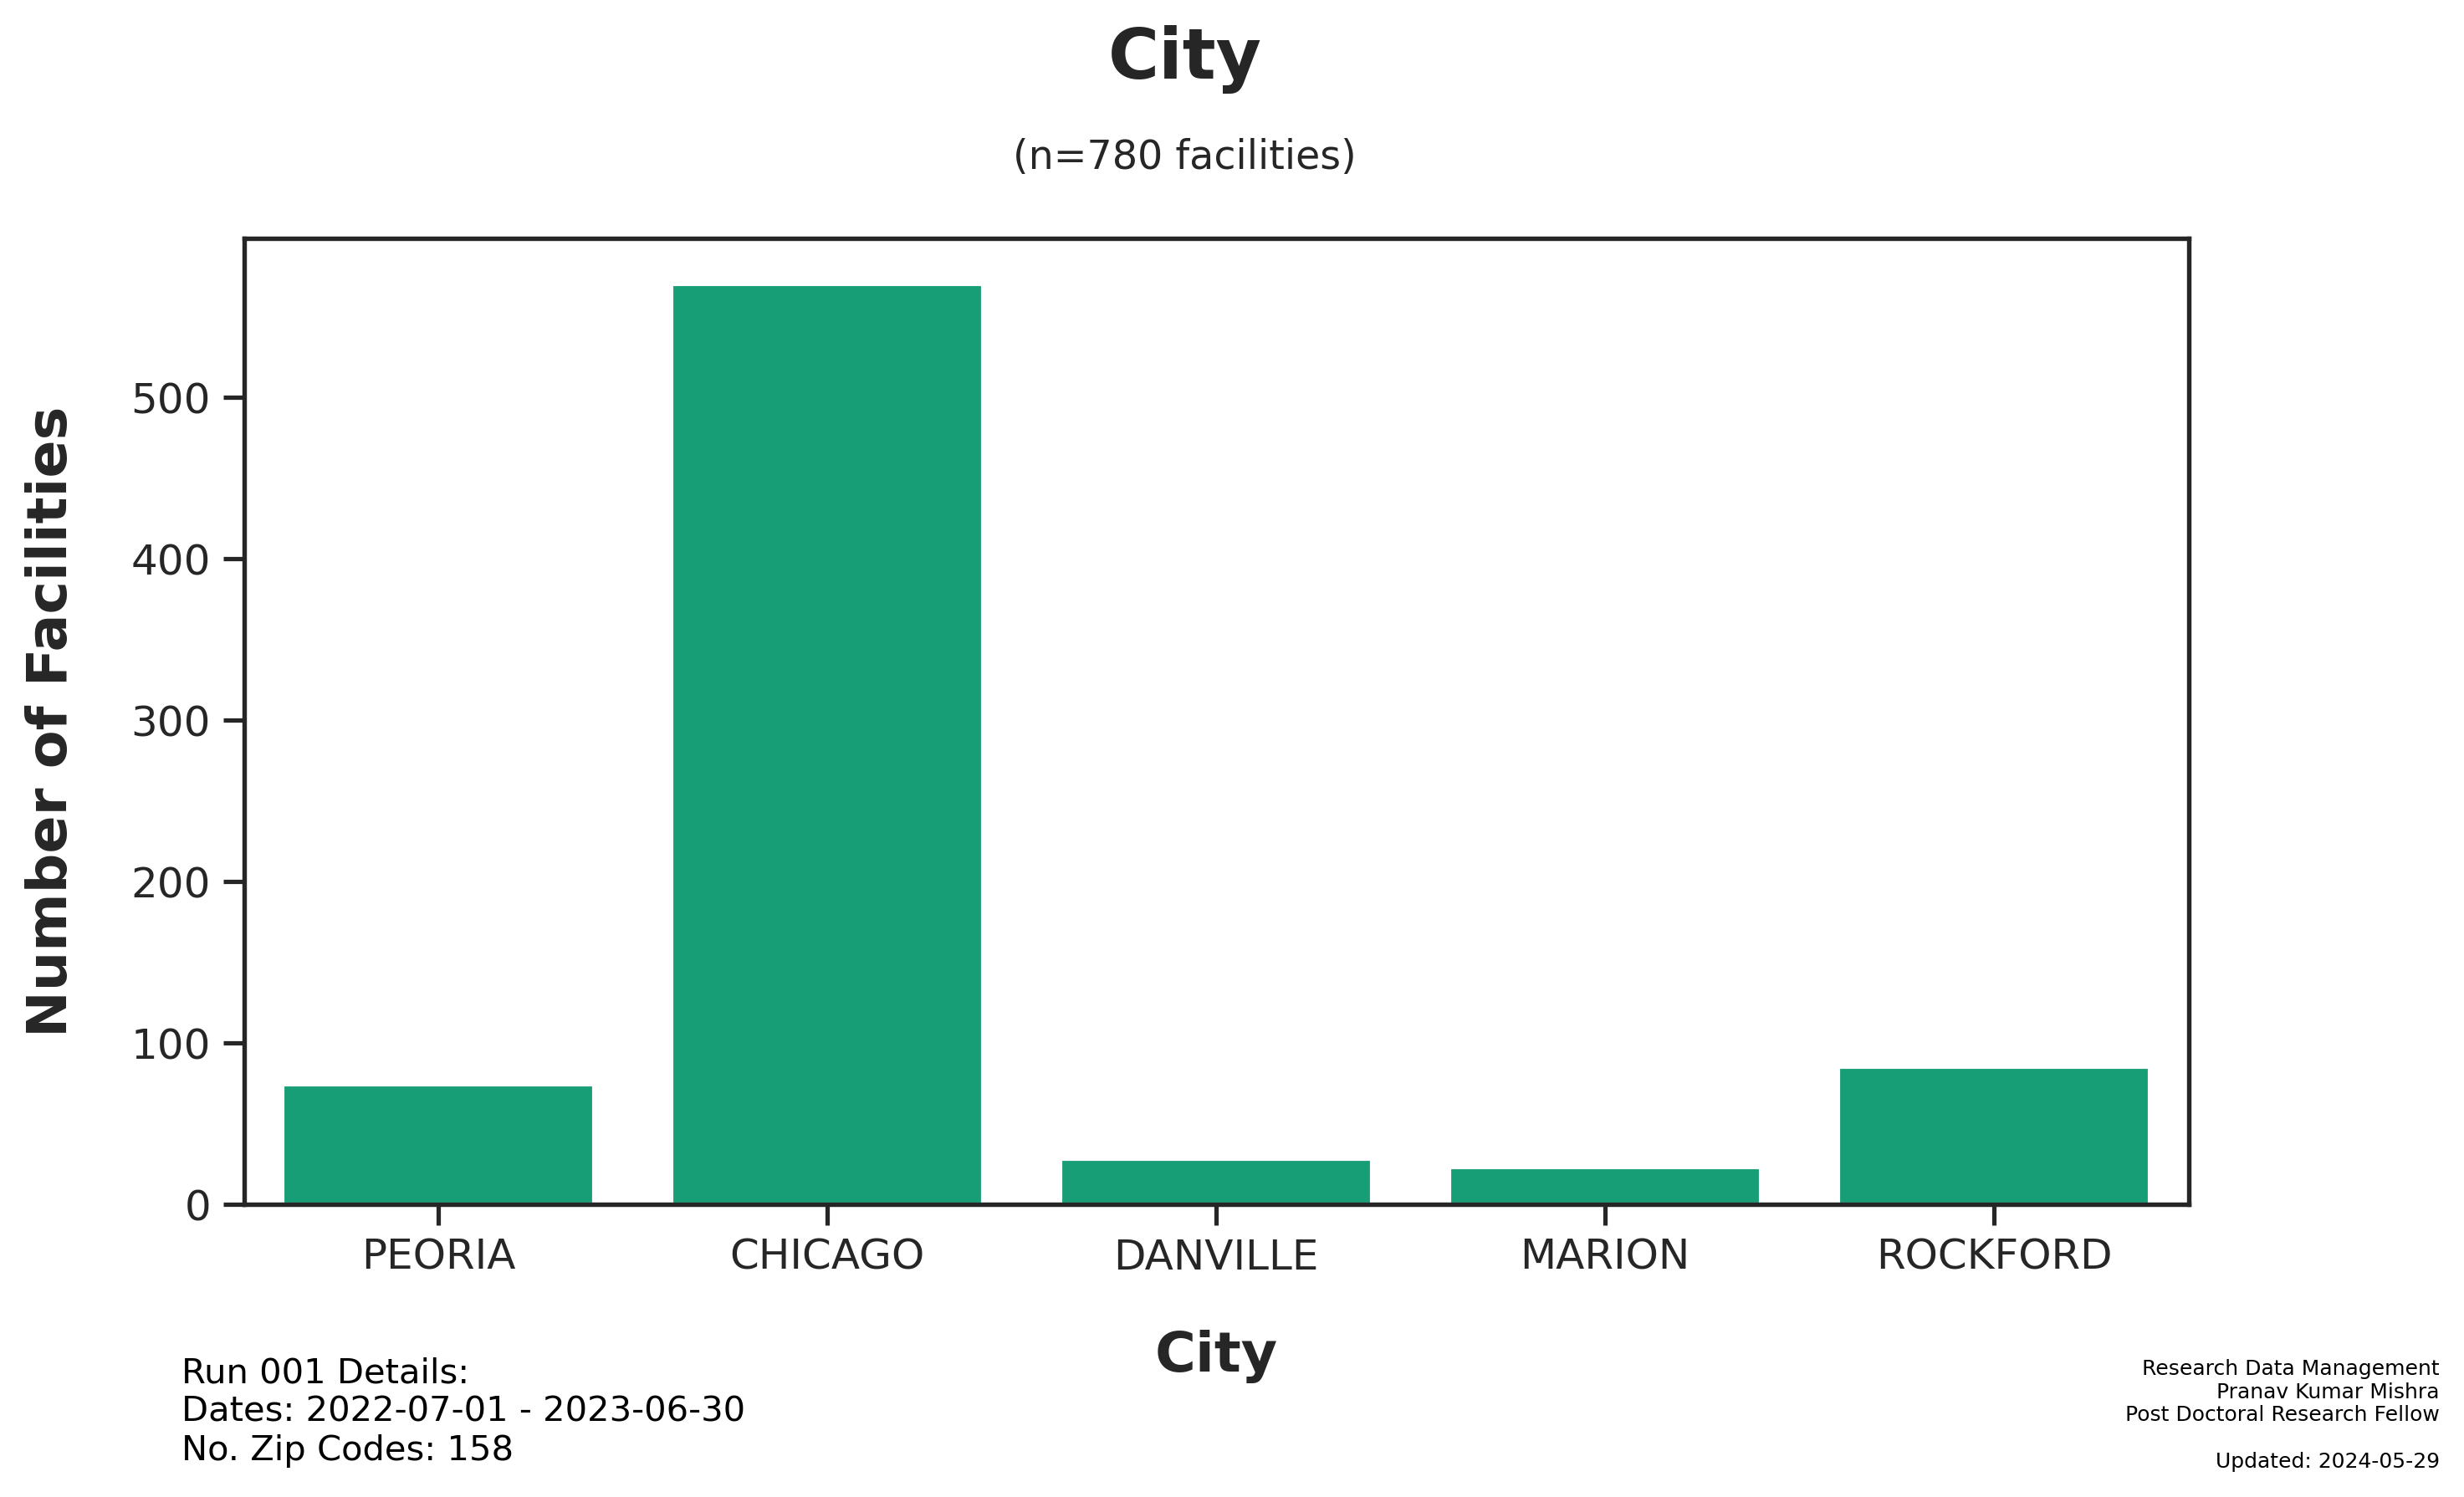

In [21]:
# City Count

# Define what will be plotted as the "dataset"
# -------------------------------------------------
x_variable = "City/Town"
title_prefix = r"Distribution of "

selected_variable_title = "City"


x_axis_title = r"City"
y_axis_title = r"Number of Facilities"


output_directory_major = ""
output_filename_prefix = f"Run{run_num}_TE_"
output_filename_main = f"City Count"

output_filename_suffix = ""

# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

fig1, _ = plt.subplots(figsize=(fig_width, fig_height), dpi=fig_save_dpi)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=None
)


# Define what will be plotted as the "dataset"
# -------------------------------------------------
top_cities = care_df[x_variable].value_counts().head(5).index
dataset = care_df[care_df[x_variable].isin(top_cities)].copy().dropna(subset=[selected_variable])




# Seaborn
# --------------------
ax1 = sns.countplot(data=dataset, x=x_variable, orient='v', color=rush_colors_hex[0])



# Plot traits
# ------------------

# Sample Size
n_samples, var = dataset.shape
n_samples = str(n_samples)


# Title
fig1.suptitle(
    selected_variable_title, fontsize=title_fontsize, fontweight="bold", y=1.05
)
ax1.set_title(
    "(n=" + str(n_samples) + " facilities)     ",
    size=title_fontsize / 1.75,
    #   fontweight='bold',
    pad=title_pad,
)


ax1.set_xlabel(x_axis_title, fontweight="bold", size=axes_fontsize)
ax1.set_ylabel(y_axis_title, fontweight="bold", size=axes_fontsize)

ax1.tick_params(labelsize=label_size)
ax1.get_xaxis().tick_bottom()

ax1.tick_params(which="minor", length=0)
ax1.yaxis.set_ticks_position("left")
ax1.xaxis.labelpad = axes_label_pad
ax1.yaxis.labelpad = axes_label_pad
ax1.yaxis.set_major_formatter(FormatStrFormatter("%d"))  # integer formatting


ax2 = ax1.twinx()
ax2.tick_params(which="major", length=0)
ax2.set_yticks([])
ax2.set_ylabel(" ", fontweight="bold", size=axes_fontsize)
ax2.yaxis.labelpad = axes_label_pad * 2


# Watermarks
if watermarks == True:
    # Author
    fig1.text(1,-0.1, data_source, color="black", ha="right", fontsize=6)
    # Run Details
    fig1.text(0.1, -0.1, run_details, color="black", ha='left', va='bottom', fontsize=10, alpha=1)


# Save the figure
# ------------------

if not os.path.exists(os.path.join(figure_base_path, output_directory_major)):
    os.makedirs(os.path.join(figure_base_path, output_directory_major))

for image_filetype in image_filetypes_output:
    image_path = (
        figure_base_path
        + "/"
        + output_directory_major
        + output_filename_prefix
        + output_filename_main
        + output_filename_suffix
        + f".{image_filetype}"
    )

    if save_figures == True:
        plt.savefig(image_path, dpi=fig_save_dpi, bbox_inches="tight")
        display(f"Figure saved to {image_path}")
    else:
        display(f"The variable 'save_figures' is currently set to: {save_figures}")

# Clear the figure's dataset
#---------------------------
del dataset


## Save the run dataset

In [22]:
save_tables = True

In [23]:
# Save dataframe to file
output_directory_major = f"/"
output_filename_prefix = f"Run{run_num}_"
output_filename_main = f"main_dataset"
output_filename_suffix = ""

if save_tables == True:
    save_dataframe_table(care_df, ['parquet'])
else:
        display(f"The variable 'save_tables' is currently set to: {save_tables}")

In [24]:
demo_df = care_df.sample(n=20)

# Save demo_df as a csv
output_directory_major = f"/"
output_filename_prefix = f"Run{run_num}_"
output_filename_main = f"demo_selected"
output_filename_suffix = ""

if save_tables == True:
    save_dataframe_table(demo_df, ['csv'])
else:
        display(f"The variable 'save_tables' is currently set to: {save_tables}")

In [25]:
# Generate run summary

def list_files_as_markdown(directory):
    markdown_list = ""
    for root, dirs, files in os.walk(directory):
        for file in files:
            relative_path = os.path.relpath(os.path.join(root, file), directory)
            markdown_list += f"- {relative_path}\n"
    return markdown_list

def list_image_files_as_markdown(directory):
    image_extensions = (".png", ".jpg", ".svg")
    markdown_list = ""
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                relative_path = os.path.relpath(os.path.join(root, file), directory)
                markdown_list += f"![{file}]({relative_path})\n\n"
    return markdown_list

md_text = f"""---  
title: Run {run_num} Summary
subtitle: "An analysis of the MBSA-QIP Dataset"  
date: last-modified  
date-format: full  
author:  
  - name:  
      given: Pranav Kumar  
      family: Mishra  
    affiliations:  
      - ref: rushsurg  
      - ref: rushortho  
    corresponding: true  
    url: https://drpranavmishra.com  
    email: pranav_k_mishra@rush.edu  
    orcid: 0000-0001-5219-6269    
    role: "Post Doctoral Research Fellow"  
format:  
  html:  
    code-fold: true  
  pdf:  
    documentclass: scrartcl  
    toc-depth: 3  
    code-fold: true  
    highlight-style: github  
    colorlinks: true  
    tbl-cap-location: bottom  
  gfm:  
    preview-mode: raw  
---



# Run {run_num} Summary

Generated: {file_date}

## Run Parameters:

- Zip Codes: `{zip_start} - {zip_end}`


## Dataset

- Subjects: `{comma_formatted_num(care_df.shape[0])}`
- [Main Dataset Parquet](data/analysis/timely_effective/runs/run_{run_num}/tables/Run{run_num}_main_dataset.parquet)
- [Demo CSV - Random 20 Subjects](data/analysis/timely_effective/runs/run_{run_num}/tables/Run{run_num}_demo_selected.csv)

## Figures

{list_image_files_as_markdown(this_run_directory)}


## Files

The following files were generated from Run {run_num}:

{list_files_as_markdown(this_run_directory)}


"""



# Save md_text to a run readme file

quarto_path = os.path.join(os.environ['repo_root'], this_run_directory, "readme.md")

with open(quarto_path, "w") as f:
    f.write(md_text)